## Re-calculate market access to compare added access from regional cities.
Use Mapbox API to calcuate travel time to major domestic and neighboring cities (population greater than 50k).  
Use district centroids as origins.  
Run market access calculation again.  

In [1]:
import os, sys, time, importlib, glob

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/Repos/GOSTnets')

import GOSTnets as gn
import rasterio as rio
from osgeo import gdal
import GOSTnets.calculate_od_raw as calcOD
import numpy as np

sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator
from infrasap import mapbox_helper as mb

from shapely.wkt import loads
from dotenv import load_dotenv, find_dotenv
from utm_zone import epsg as epsg_get
import json

%load_ext autoreload
%autoreload 2

In [2]:
country = 'mauritania'
iso3 = 'MRT'

In [3]:
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
mb_token = os.environ.get("MB_TOKEN")

### Load data

In [4]:
# base_in = "/home/public/Data/PROJECTS/INFRA_SAP"
base_in = "/home/wb514197/data/INFRA_SAP"
in_folder = os.path.join(base_in, iso3)

# define data paths
focal_admin2 = os.path.join(in_folder, "admin.shp")
focal_osm = os.path.join(in_folder, f"{country}-latest.osm.pbf")
pop_name = "WP_2020_1km"
wp_1km = os.path.join(in_folder, f"{pop_name}.tif")
urban_extents = os.path.join(in_folder, "urban_extents.shp")
airports = os.path.join(in_folder, "airports.shp")
ports = os.path.join(in_folder, "ports.shp")
borders = os.path.join(in_folder, "borders.shp")

# base_out = "/home/wb514197/data/INFRA_SAP" # GOT permission denied using public 
# out_folder = os.path.join(base_out, iso3)
# if not os.path.exists(out_folder):
#     os.makedirs(out_folder)

out_folder = os.path.join(in_folder, "output")

# global_cities = '/home/public/Data/PROJECTS/LAC_GOSTNets/Destinations/Cities_centroids_FINAL_pop.shp'
global_admin = '/home/public/Data/GLOBAL/ADMIN/g2015_0_simplified.shp'
# global_cities = '/home/public/Data/GLOBAL/Population/Major_Cities.shp'
global_cities = '/home/public/Data/GLOBAL/Population/global_settlement_points_v1_01_gt50000.shp'

In [5]:
bounds = gpd.read_file(focal_admin2)
bounds_json = json.loads(bounds.to_json())
epsg = epsg_get(bounds_json)
utm = f"EPSG:{epsg}"

In [6]:
target = gpd.read_file(focal_admin2)
target['centroid'] = target.centroid
cities = gpd.read_file(global_cities)
adm0 = gpd.read_file(global_admin)
adm0 = adm0.loc[adm0.is_valid]
cities = gpd.sjoin(cities, adm0[['ADM0_NAME','geometry']], how='left')

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [7]:
pop_thresh = 50000
dist_thresh = 100000 # meters
cities = cities[cities.Pop>pop_thresh].copy()

cities_proj = cities.to_crs(f'EPSG:{epsg}')
target_proj = target.to_crs(f'EPSG:{epsg}')

In [8]:
target_buffer = target_proj.buffer(dist_thresh)
cities_filter = cities_proj[cities_proj.intersects(target_buffer.unary_union)]

In [9]:
# Remove cities from the target country
cities_filter = cities_filter[cities_filter.ADM0_NAME!=country].copy()
cities_filter = cities_filter.to_crs(cities.crs)

In [10]:
cities_adm0 = gpd.read_file(urban_extents)
cities_adm0 = cities_adm0[cities_adm0.Pop>pop_thresh]
cities_adm0['geometry'] = cities_adm0.geometry.centroid

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
cities_concat = pd.concat([cities_filter, cities_adm0]).reset_index(drop=True)

In [12]:
cities_concat.head()

,OBJECTID,UNSD,Latlongid,Latitude,Longitude,Pop,Year,Urborrur,Schnm,Name1,...,ES90POP,ES95POP,ES00POP,INSGRUSED,Continent,Country,geometry,index_right,ADM0_NAME,ID
0,0.0,466.0,67.0,14.442410,-11.431699,66865.0,1998.0,U,KAYES,Kayes,...,42739.0,53352.0,66865.0,N,Africa,Mali,POINT (-11.43170 14.44241),47.0,Mali,NaN
1,0.0,478.0,39.0,16.150000,-13.500000,50269.0,1996.0,U,KAEDI,Kaédi,...,30668.0,39264.0,50269.0,Y-Urban,Africa,Mauritania,POINT (-13.50000 16.15000),46.0,Mauritania,NaN
2,0.0,478.0,44.0,16.616667,-11.400000,53378.0,1996.0,U,KIFFA,Kiffa,...,32369.0,41567.0,53378.0,Y-Urban,Africa,Mauritania,POINT (-11.40000 16.61667),46.0,Mauritania,NaN
3,0.0,478.0,59.0,20.900000,-17.060000,107865.0,1996.0,U,NOUADHIBOU,Nouadhibou,...,65424.0,84006.0,107865.0,Y-Urban,Africa,Mauritania,POINT (-17.06000 20.90000),46.0,Mauritania,NaN
4,0.0,478.0,63.0,18.100000,-15.950000,739993.0,1996.0,U,NOUAKCHOTT,Nouakchott,...,453236.0,579130.0,739993.0,Y-Urban,Africa,Mauritania,POINT (-15.95000 18.10000),46.0,Mauritania,NaN


<AxesSubplot:>

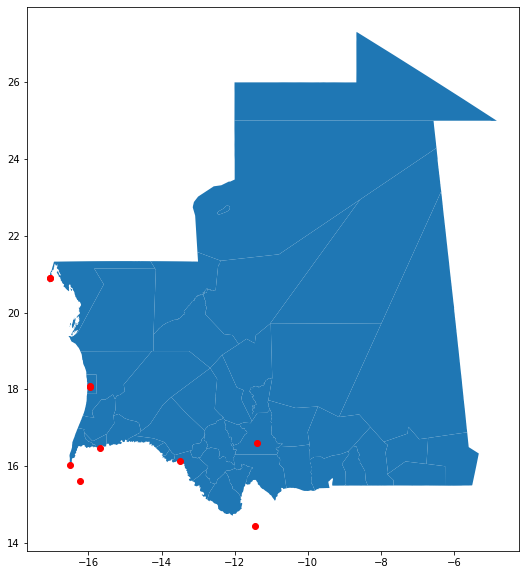

In [13]:
ax = target.plot(figsize=(10, 10))
cities_concat.plot(figsize=(10, 10), ax=ax, color='red')

In [14]:
origins = target.copy()
dests = cities_concat.copy().reset_index(drop=True)

In [15]:
origins['x'] = origins.centroid.x
origins['y'] = origins.centroid.y

dests['x'] = dests.geometry.x
dests['y'] = dests.geometry.y

origins['ID'] = origins.OBJECTID
dests['ID'] = dests.index

origins['Pop'] = 1

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [16]:
odRes = mb.CreateODMatrix(origins, dests, lat_name = 'y', lon_name = 'x', UID = 'ID', 
                    Pop = 'Pop', call_type = 'MB', rescue = 0, rescue_num = 0, MB_Toke = mb_token, 
                    sleepTime = 5, osrmHeader = '')


Chosen server: MB

Start time: Fri Mar  5 16:01:11 2021
source list: 45
sources list: 4
dest list: 10
dests list: 1

Estimated remaining calls to chosen server: 4

save points will occur every 1 calls

Call to OSRM server number: 1 of 4
Call to OSRM server number: 2 of 4
Call to OSRM server number: 3 of 4
Call to OSRM server number: 4 of 4


In [17]:
odRes['O_UID'] = odRes['O_UID'].astype('int')
odRes['D_UID'] = odRes['D_UID'].astype('int')

In [18]:
OD_re = odRes.pivot(index='O_UID', columns='D_UID', values='DIST')

In [19]:
OD_re.head()

D_UID,0,1,2,3,4,5,6,7,8,9
O_UID,,,,,,,,,,
22900,89007.1,55633.7,60859.2,40121.0,22003.1,51299.3,43860.2,49533.7,39989.4,22638.3
22901,89637.4,56264.0,61489.5,40751.3,22633.4,51929.6,44490.5,50164.0,40619.7,23268.6
22902,454733.8,422361.8,427587.3,374857.2,388483.1,417026.0,409586.9,415260.4,374725.6,388589.4
22903,99861.1,66487.7,71713.2,50975.0,32857.1,62153.3,54714.2,60387.7,50843.4,33492.3
22904,57221.8,33363.0,17200.1,58669.8,39888.1,67985.7,60546.6,66220.1,58538.2,39737.7


In [20]:
dests.Pop[OD_re.columns]

D_UID
0    6.686500e+04
1    5.026900e+04
2    5.337800e+04
3    1.078650e+05
4    7.399930e+05
5    7.053300e+04
6    6.269400e+04
7    1.563370e+05
8    1.828651e+05
9    1.359739e+06
Name: Pop, dtype: float64

In [21]:
access_regional = calcOD.calculate_gravity(np.array(OD_re), dWeight = dests.Pop[OD_re.columns])

In [22]:
# access_domestic = calcOD.calculate_gravity(np.array(OD_re.loc[:,1:]), dWeight = dests.Pop[OD_re.loc[:,1:].columns])
# if adm0 name is null, then it's a domestic city
access_domestic = calcOD.calculate_gravity(np.array(OD_re.loc[:,dests.loc[dests.ADM0_NAME.isnull()].index]), 
                                           dWeight = dests.Pop[dests.loc[dests.ADM0_NAME.isnull()].index])

In [23]:
access_regional = access_regional.rename(columns = {
        'd_0.01': 'ma_reg_1',
        'd_0.005': 'ma_reg_2',
        'd_0.001' : 'ma_reg_3',
        'd_0.0007701635' : 'ma_reg_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'ma_reg_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'ma_reg_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'ma_reg_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'ma_reg_8',   # Market access halves every 300 mins
        'd_1e-05' : 'ma_reg_9'
    })

access_domestic = access_domestic.rename(columns = {
        'd_0.01': 'ma_dom_1',
        'd_0.005': 'ma_dom_2',
        'd_0.001' : 'ma_dom_3',
        'd_0.0007701635' : 'ma_dom_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'ma_dom_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'ma_dom_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'ma_dom_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'ma_dom_8',   # Market access halves every 300 mins
        'd_1e-05' : 'ma_dom_9'
    })

In [24]:
access_pch = pd.DataFrame((access_regional.values-access_domestic.values)/access_domestic.values,
             index = access_regional.index,
             columns=['ma_pch_1', 'ma_pch_2', 'ma_pch_3', 'ma_pch_4',
                      'ma_pch_5', 'ma_pch_6', 'ma_pch_7', 'ma_pch_8', 'ma_pch_9'])

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [25]:
access_pdif = pd.DataFrame((access_regional.values-access_domestic.values)/((access_regional.values+access_domestic.values)/2),
             index = access_regional.index,
             columns=['ma_pdif_1', 'ma_pdif_2', 'ma_pdif_3', 'ma_pdif_4',
                      'ma_pdif_5', 'ma_pdif_6', 'ma_pdif_7', 'ma_pdif_8', 'ma_pdif_9'])

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [26]:
access_join = access_domestic.loc[:,'ma_dom_5':].join(access_regional.loc[:,'ma_reg_5':]).join(access_pch.loc[:,'ma_pch_5':]).join(access_pdif.loc[:,'ma_pdif_5':])
access_join['OBJECTID'] = OD_re.index
newdf = target.merge(access_join, on='OBJECTID')
newdf.drop(['geometry','Shape_Leng','Shape_Area'], axis=1, inplace=True)

In [27]:
output_path = os.path.join(out_folder, 'tables')
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [28]:
newdf.to_excel(os.path.join(output_path, "11Regional Analysis.xlsx"), index=False)